<a href="https://colab.research.google.com/github/GantMan/MachineLearningTraining/blob/master/Truck_Identifier_From_Scratch_w_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simple machine learning to identify if a photo is a Truck

Let's make a model to train with Keras that identifies trucks.  We'll be sure to use the TensorFlow version of Keras, so we can partake in several benefits.



In [0]:
# Must grab keras from tensorflow for TPU!
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
# This is found in a different spot in vanilla Keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt

We'll be using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class, all labeled.  

This fortunately comes with an existing training/testing split ready to go right in Keras!  Thanks [pre-existing Keras datasets](https://keras.io/datasets/)!

In [0]:
# Load data set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

**The dataset is labeled with the following 10 numerical outcomes.**

0.   Airplane
1.   Automobile
2.   Bird
3.   Cat
4.   deer
5.   dog
6.   frog
7.   horse
8.   ship
9.   truck


In [0]:
def visualize_classes():
  graphic = []
  for i in range(0, 10):
      img_batch = x_train[y_train.flatten() == i][0:10] # 10 examples of each class
      combo = np.concatenate(img_batch, axis = 0) # combine into an image
      graphic.append(combo)
  plt.figure(figsize=(12,24))
  plt.axis('off')
  plt.imshow(np.concatenate(graphic, axis = 1))



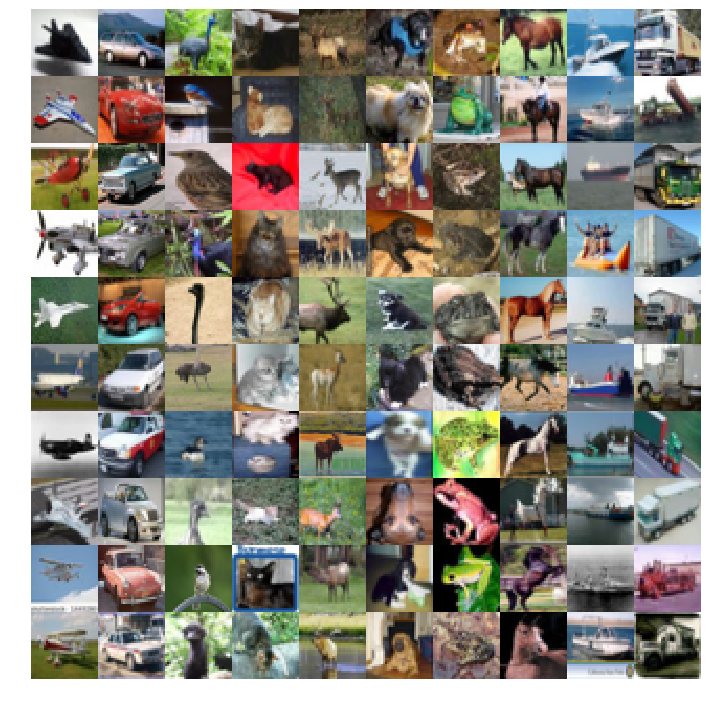

In [4]:
visualize_classes()


We use a bit of boolean broadcasting to convert the numeric items to booleans.  We'll set truch to `true`, and all others to `false`.


In [0]:
# adjust it so instead it sets all trucks to true and everything else to false
# broadcast boolean logic througout dataset
y_train = y_train == 9
y_test = y_test == 9

In [0]:
# prepare x to be normalized (between 0 and 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
model = Sequential()

model.add(
    Conv2D(
        32,
        (3, 3),
        padding='same',
        input_shape=(32, 32, 3),
        activation="relu"
    )
)
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

![pool after conv](https://pbs.twimg.com/media/DwCNkbIW0AENQy6.jpg =400x)

In [0]:
# second grouping
model.add(
    Conv2D(64, (3, 3), padding='same', activation="relu")
)
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

## Adding L2 Regularization

Regularization helps values that go too small, or too big for your computer from ruining everything.  Exploding and vanishing gradients, even if they don't crash your machine, can slow things downt o a crawl.   Regularization helps!   L2 is the most popular, unless you're looking to significantly remove useless inputs.  In those cases the more agressive L1 regularization would work.

In [0]:
# Final dense layer
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(0.01)))


In [0]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
)

## Training with that GPU goodness

![GPU yum](https://pbs.twimg.com/media/DrdQ4MIXgAIgIAG.jpg)

To train we call `fit` on the model and we wait.  An epoch on a fast CPU is around 5 minutes.

In [11]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=1,
    validation_data=(x_test, y_test),
    shuffle=True
)



Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 320s 6ms/step - loss: 0.2599 - acc: 0.9018 - val_loss: 0.2189 - val_acc: 0.9158


### CPU model training: ~5 minutes/epoch

### GPU model training ~30 seconds/epoch

But we're on Google Collab... we can go further.

TPUs are tensor processing units developed by Google to  accelerate operations on a Tensorflow Graph. Each TPU packs up to 180 teraflops of floating-point performance and 64 GB of high-bandwidth memory onto a single board. 

**TPUs are considered roughly 10 to 20 times better than GPUs!**


In [12]:
import os
# This address identifies the TPU we'll use when configuring TensorFlow.

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
# Optional for more info
# tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.99.228.154:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 10181753667784127686)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4386144145425028590)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 11826148583539772012)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11683280334758815369)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15923823443231023818)
INFO:tensorflow:*** Available Device: _Dev

In [13]:
tpu_model.fit(
    x_train,
    y_train,
    batch_size=1024,
    epochs=3,
    validation_data=(x_test, y_test),
    shuffle=True
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='conv2d_input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='dense_1_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for conv2d_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f80b5f60c88> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.526151657104492 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU beta_1: 0.8999999761581421 {0.9}
INFO

![TPU](https://i.imgur.com/tD7ygmu.png =600x)


Now we can save our trained model to disk.

In [14]:
tpu_model.save("scratch_truck_model.h5")

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False


At any time we can load this saved model.  We would import `load_model` from `keras.models` and call that with our model file 'scratch_truck_model.h5'.

If we wanted to use the TPU model we trained, we'll need to process 8 images at a time (batch size equal to the number of cores.   So instead, from here forward we'll use our **"loaded_model"**). 

Another way around this is to take your model and make a CPU version of it for predicting.  You can do this with `cpu_model = tpu_model.sync_to_cpu()`, and then use `cpu.predict`.

In [0]:
from tensorflow.keras.models import load_model 

loaded_model = load_model('scratch_truck_model.h5')

In [0]:
from tensorflow.keras.preprocessing import image
from pathlib import Path

**We'll try showing our model the following 2 images:**

This 32x32x3 truck -  ![truck](https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck2.png) as `truck.png`

And this 32x32x3 bird -  ![bird](https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird8.png) as `not_truck.png`

In [17]:
import urllib.request

urllib.request.urlretrieve ("https://www.cs.toronto.edu/~kriz/cifar-10-sample/truck2.png", "truck.png")
urllib.request.urlretrieve ("https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird8.png", "not_truck.png")


('not_truck.png', <http.client.HTTPMessage at 0x7f80b0f24ac8>)

![wut cifar image](https://pbs.twimg.com/media/DwCQutKW0AAUKqk.jpg =400x)

In [18]:
for f in sorted(Path(".").glob("*.png")):
    # Load an image file to test
    image_to_test = image.load_img(
        str(f),
        target_size=(32, 32)
    )

    # Convert the image data to a numpy array
    # suitable for Keras
    image_to_test = image.img_to_array(image_to_test)
    # normalize to a 0 to 1 value
    image_to_test /= 255

    # Add a fourth dimension to the image since
    # Keras expects a list of images
    list_of_images = np.expand_dims(
        image_to_test,
        axis=0
    )
    # Make a prediction using the truck model
    results = loaded_model.predict(list_of_images)

    # Since we only passed in one test image,
    # we can just check the first result directly.
    image_likelihood = results[0][0]

    # The result will be a number from 0.0 to 1.0
    # representing the likelihood that this
    # image is a truck.
    if image_likelihood > 0.5:
        print(f"{f} is a truck! ({image_likelihood:.2f})")
    else:
        print(f"{f} is NOT a truck! ({image_likelihood:.2f})")

not_truck.png is NOT a truck! (0.00)
truck.png is NOT a truck! (0.01)


![confusion matrix](https://www.dataschool.io/content/images/2015/01/confusion_matrix2.png)

In [19]:
from sklearn.metrics import classification_report

predictions = loaded_model.predict(x_test, batch_size=32, verbose=1)
# If the model is more than 50% sure the object is a truck, call it a truck.
# Otherwise, call it "not a truck" via boolean
predictions = predictions > 0.5

# Calculate Precision and Recall for each class
report = classification_report(y_test, predictions)
print(report)

10000/10000 [==============================] - 3s 291us/step
              precision    recall  f1-score   support

       False       0.95      0.99      0.97      9000
        True       0.86      0.49      0.62      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.90      0.74      0.80     10000
weighted avg       0.94      0.94      0.93     10000



F-score (F1 score) is the harmonic mean of precision and recall:

>$F1=2*\frac{precision*recall}{precision+recall}$

Basically a way for us to give some kind of combo-score to their trade-offs.

In [20]:
%%bash
pip install tensorflowjs
tensorflowjs_converter --input_format keras \
                       ./scratch_truck_model.h5 \
                       ./tfjs_target_dir

  Found existing installation: Keras-Applications 1.0.6
    Uninstalling Keras-Applications-1.0.6:
      Successfully uninstalled Keras-Applications-1.0.6
  Found existing installation: Keras-Preprocessing 1.0.5
    Uninstalling Keras-Preprocessing-1.0.5:
      Successfully uninstalled Keras-Preprocessing-1.0.5


tensorflow 1.12.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.4 which is incompatible.
tensorflow 1.12.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.
Using TensorFlow backend.


In [21]:
!ls ./tfjs_target_dir

group1-shard1of2  group1-shard2of2  model.json


![me](https://pbs.twimg.com/media/DvFA7pNV4AAiW49.jpg =400x)